In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# This notebook was created to construct a supplementary table with *accession IDs* for all isolates in our sample and to identify the geographical origin of each isolate for isolates that have this meta-data

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio import Phylo

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy
from collections import Counter
from itertools import groupby
from operator import itemgetter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

####################################################################################################################################################################################

# [1] Load Sample Annotation Files & Sample Metadata Files

####################################################################################################################################################################################

In [3]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')

Columns of Genotype Matrix

In [4]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [5]:
np.shape(isolate_annotation_DF)

(31428, 14)

Rows of Genotype Matrix

In [6]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,48,C,[T],Rv0001,47.0,Essential,dnaA
1,64,G,[C],Rv0001,63.0,Essential,dnaA
2,67,G,"[A, T]",Rv0001,66.0,Essential,dnaA
3,69,C,[T],Rv0001,68.0,Essential,dnaA
4,71,C,[T],Rv0001,70.0,Essential,dnaA


In [7]:
np.shape(SNP_annotation_DF)

(782565, 7)

#### Retrieve geographical data for isolates

In [8]:
geographic_isolate_df_A = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/RRDR_mutant_project/GEO data/geo_sampling.txt', sep="\t", header=0).set_index('BioSample')
geographic_isolate_df_B = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/RRDR_mutant_project/GEO data/validation_ids_TableS4.csv', sep=",", header=0).set_index('Isolate ID')

In [9]:
geographic_isolate_df_A.head(n=3)

,isolation_country,collection_year,tag
BioSample,,,
SAMEA787746,Uganda,2005.0,"patric,ncbi"
SAMN08684019,Lebanon,2017.0,"patric,ncbi"
SAMN09566410,South Africa,2011.0,"patric,ncbi"


In [10]:
np.shape(geographic_isolate_df_A)

(64933, 3)

In [11]:
geographic_isolate_df_B.head(n=3)

,Count,Source,Lab,Country
Isolate ID,,,,
1478813216721T177115lib4769nextseqn0035151bp,1,ReseqTB,Borstel,Germany
1478813216721T177215lib4770nextseqn0035151bp,2,ReseqTB,Borstel,Germany
1478813216721T177315lib4771nextseqn0035151bp,3,ReseqTB,Borstel,Germany


In [12]:
np.shape(geographic_isolate_df_B)

(792, 4)

####################################################################################################################################################################################

# [2] Table with all BioSample / Patric IDs for Supplementary Materials

####################################################################################################################################################################################

# [2.1] check sample accessions and bin into sample category

#### Add accession IDs (NCBI) for additional 12 *eis* C-14T mutants with AG MICs

- IT123: SAMN21438148 (PRJNA763160)
- IT184: SAMN21438149 (PRJNA763160)
- IT952: SAMN21438150 (PRJNA763160)
- IT524: SAMN21438151 (PRJNA763160)
- 655-19: SAMN21438152 (PRJNA763160)
- IT233: ERS2395000 (PRJEB25972)
- IT77: ERS2394970 (PRJEB25972)
- 622-19: SAMN21438153 (PRJNA763160)
- IT1070: SAMN21438154 (PRJNA763160)
- IT947: SAMN21438155 (PRJNA763160)
- 168-19: SAMN21438156 (PRJNA763160)
- IT634: ERS2395185 (PRJEB25972)

In [192]:
# store each isolate ID and relevant info
isolate_tag_list = ['IT123','IT184','IT952','IT524','655-19','IT233','IT77','622-19','IT1070','IT947','168-19','IT634']
isolate_accession_ID_list = ['SAMN21438148','SAMN21438149','SAMN21438150','SAMN21438151','SAMN21438152','ERS2395000','ERS2394970','SAMN21438153','SAMN21438154','SAMN21438155','SAMN21438156','ERS2395185']
isolate_info_list = ['ncbi']*12

# create sets from DataFrame indices for faster checking
geographic_isolate_df_A_IDs = set(geographic_isolate_df_A.index)
geographic_isolate_df_B_IDs = set(geographic_isolate_df_B.index)

#iterate through each isolate ID and check to see if it has associated info in either DataFrame
for isolate_ID in isolate_annotation_DF.isolate_ID:
    
    if isolate_ID in geographic_isolate_df_A_IDs:
        isolate_tag_list.append(isolate_ID)
        
        if geographic_isolate_df_A.loc[isolate_ID, 'tag'] == 'farhat_lab:cetr':
            isolate_accession_ID_list.append('farhat_nat_comm_2019')
            isolate_info_list.append('ncbi')
        else:
            isolate_accession_ID_list.append(isolate_ID)
            isolate_info_list.append(geographic_isolate_df_A.loc[isolate_ID, 'tag'])
        
    elif isolate_ID in geographic_isolate_df_B_IDs:
        isolate_tag_list.append(isolate_ID)
        
        if geographic_isolate_df_B.loc[isolate_ID, 'Source'] == 'farhat_lab:cetr':
            isolate_accession_ID_list.append('farhat_nat_comm_2019')
            isolate_info_list.append('ncbi')
        else:
            isolate_accession_ID_list.append(isolate_ID)
            isolate_info_list.append(geographic_isolate_df_B.loc[isolate_ID, 'Source'])
        
    elif ((len(isolate_ID) == 6) or (len(isolate_ID) == 7) or (len(isolate_ID) == 8)) and ('R' in isolate_ID):
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append('farhat_nat_comm_2019')
        isolate_info_list.append('ncbi')
        
    elif ('Peru' in isolate_ID):
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append('farhat_nat_comm_2019')
        isolate_info_list.append('ncbi')

    elif isolate_ID[0:3] == 'TDR':
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append('farhat_nat_comm_2019')
        isolate_info_list.append('ncbi')

    elif isolate_ID[0:3] == 'SAM':
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append(isolate_ID)
        isolate_info_list.append('ncbi')
        
    elif isolate_ID[0:3] == 'ERR':
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append(isolate_ID)
        isolate_info_list.append('ena')
        
    elif (len(isolate_ID) == 7):
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append('farhat_nat_comm_2019')
        isolate_info_list.append('ncbi')
        
    else:
        isolate_tag_list.append(isolate_ID)
        isolate_accession_ID_list.append('N/A')
        isolate_info_list.append('N/A')
        
# construct DataFrame from lists
supplementary_table_isolate_IDs = pd.DataFrame()
supplementary_table_isolate_IDs['sample ID'] = isolate_tag_list
supplementary_table_isolate_IDs['accession ID'] = isolate_accession_ID_list
supplementary_table_isolate_IDs['INFO'] = isolate_info_list

In [193]:
supplementary_table_isolate_IDs.head(n = 20)

,sample ID,accession ID,INFO
0,IT123,SAMN21438148,ncbi
1,IT184,SAMN21438149,ncbi
2,IT952,SAMN21438150,ncbi
3,IT524,SAMN21438151,ncbi
4,655-19,SAMN21438152,ncbi
5,IT233,ERS2395000,ncbi
6,IT77,ERS2394970,ncbi
7,622-19,SAMN21438153,ncbi
8,IT1070,SAMN21438154,ncbi
9,IT947,SAMN21438155,ncbi


In [194]:
np.shape(supplementary_table_isolate_IDs)

(31440, 3)

# [2.2] check sample accessions that haven't been deposited

In [195]:
supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.INFO == 'N/A']

,sample ID,accession ID,INFO
7626,1479144119992T178715lib4992nextseqn0036151bp,N/A,N/A
9270,1479144119992T178015lib4985nextseqn0035151bp,N/A,N/A
22582,1479144813357T180715lib5012nextseqn0035151bp,N/A,N/A


In [196]:
np.shape(supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.INFO == 'N/A'])

(3, 3)

In [197]:
isolate_annotation_DF[isolate_annotation_DF.isolate_ID == '1479144119992T178715lib4992nextseqn0036151bp']

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
7614,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1479144119992T178715lib4992nextseqn0036151bp,2.2.2,2


In [198]:
isolate_annotation_DF[isolate_annotation_DF.isolate_ID == '1479144119992T178015lib4985nextseqn0035151bp']

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
9258,2,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1479144119992T178015lib4985nextseqn0035151bp,2.2.1.1.1,2


In [199]:
isolate_annotation_DF[isolate_annotation_DF.isolate_ID == '1479144813357T180715lib5012nextseqn0035151bp']

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
22570,2,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1479144813357T180715lib5012nextseqn0035151bp,2.2.1.1.1,2


All **"147"** isolates came from the same source

In [200]:
set(geographic_isolate_df_B[[('147' == isolate_ID[0:3]) for isolate_ID in geographic_isolate_df_B.index]].Source)

{'ReseqTB'}

In [201]:
set(geographic_isolate_df_B[[('147' == isolate_ID[0:3]) for isolate_ID in geographic_isolate_df_B.index]].Lab)

{'Borstel'}

In [202]:
set(geographic_isolate_df_B[[('147' == isolate_ID[0:3]) for isolate_ID in geographic_isolate_df_B.index]].Country)

{'Germany'}

### Replace N/A values with accession IDs that were uploaded to NCBI

- 1479144119992T178715lib4992nextseqn0036151bp: SAMN21441812
- 1479144119992T178015lib4985nextseqn0035151bp: SAMN21441811
- 1479144813357T180715lib5012nextseqn0035151bp: SAMN21441813

In [203]:
supplementary_table_isolate_IDs.loc[7626, ['accession ID','INFO']] = ['SAMN21441812','ncbi']
supplementary_table_isolate_IDs.loc[9270, ['accession ID','INFO']] = ['SAMN21441811','ncbi']
supplementary_table_isolate_IDs.loc[22582, ['accession ID','INFO']] = ['SAMN21441813','ncbi']

In [204]:
supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.INFO == 'N/A']

,sample ID,accession ID,INFO


# [2.3] check sample accessions that belong to *peru* samples from *NatComm* 2019 paper

In [205]:
supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.loc[:,'accession ID'] == 'farhat_nat_comm_2019'].head()

,sample ID,accession ID,INFO
45,02R1945,farhat_nat_comm_2019,ncbi
61,01R0685,farhat_nat_comm_2019,ncbi
63,Peru4532,farhat_nat_comm_2019,ncbi
90,TDR236S160L002,farhat_nat_comm_2019,ncbi
111,TDR94S189L002,farhat_nat_comm_2019,ncbi


In [206]:
np.shape(supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.loc[:,'accession ID'] == 'farhat_nat_comm_2019'])

(1226, 3)

#### Load in the CSV file that contains annotation information from isolates examined in *Farhat et al (2019) Nature Communications*

In [207]:
farhat_2019_natcomm_annot_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/41467_2019_10110_MOESM4_ESM.csv')

In [208]:
farhat_2019_natcomm_annot_df.head()

,BioProject,Run No,BioSample,WGSAccessionNumber OR Run Accession,ID,Alt ID,PATIENT_ID1,PATIENT_ID2,Country of Isolation,Phylogenetic lineage,spoligotype family,Coll et al Barcode based lineage
0,PRJEB26000,NaN,ERS2401270,ERR2516592,00-R0223,00-R0223,NaN,NaN,Peru,4.8,Haarlem,"lineage4,lineage4.8"
1,PRJEB26000,NaN,ERS2401327,ERR2516649,00-R0312,00-R0312,NaN,NaN,Peru,4.3,LAM,"lineage4,lineage4.3,lineage4.3.3"
2,PRJEB26000,NaN,ERS2401310,ERR2516632,00-R0435,00-R0435,NaN,NaN,Peru,NaN,NaN,"lineage4,lineage4.8"
3,PRJEB26000,NaN,ERS2401368,ERR2516690,00-R0453,00-R0453,NaN,NaN,Peru,4.3,LAM,"lineage4,lineage4.3,lineage4.3.3"
4,PRJEB26000,NaN,ERS2401251,ERR2516573,00-R1566,00-R1566,NaN,NaN,Peru,4.1,X – clade,"lineage4,lineage4.1,lineage4.1.1,lineage4.1.1.3"


In [209]:
np.shape(farhat_2019_natcomm_annot_df)

(1483, 12)

### Fill in Run Accession IDs where missing for annotation files

In [210]:
def get_missing_runIDs_from_farhat2019_NatComm(isolate_annot_df):
    
    '''
    This function takes as input a df of isolate annotations and fills in missing Run ID accessions that are available from the Farhat et. al. (2019) Nature Communications paper.
    '''

    accession_ID_list = []

    for row_i in isolate_annot_df.index:
        
        #if accession ID 'farhat_nat_comm_2019', then search for it in annotation file
        if supplementary_table_isolate_IDs.loc[row_i, 'accession ID'] == 'farhat_nat_comm_2019':
            
            sample_ID = isolate_annot_df.loc[row_i , 'sample ID']
            
            #the sample ID matches a row for an isolate in the annotation file
            if np.shape( farhat_2019_natcomm_annot_df[farhat_2019_natcomm_annot_df.ID == sample_ID] )[0] == 1:

                WGS_or_Run_Accession = farhat_2019_natcomm_annot_df[farhat_2019_natcomm_annot_df.ID == sample_ID].loc[: , 'WGSAccessionNumber OR Run Accession'].values[0]
                accession_ID_list.append(WGS_or_Run_Accession)
                
            # check for sample ID for the "TDR" farhat 2019 NatComm isolates
            elif sample_ID[0:3] == "TDR":
                
                sample_ID_TDR = 'TDR ' + sample_ID.split('TDR')[1].split('S')[0] + ' S' + sample_ID.split('TDR')[1].split('S')[1].split('L')[0] + ' L' + sample_ID.split('TDR')[1].split('S')[1].split('L')[1]
                
                if np.shape( farhat_2019_natcomm_annot_df[farhat_2019_natcomm_annot_df.ID == sample_ID_TDR] )[0] == 1:
                    
                    WGS_or_Run_Accession = farhat_2019_natcomm_annot_df[farhat_2019_natcomm_annot_df.ID == sample_ID_TDR].loc[: , 'WGSAccessionNumber OR Run Accession'].values[0]
                    accession_ID_list.append(WGS_or_Run_Accession)
                    
                else:
                    accession_ID_list.append('PRJEB31023')
                    
            # check for sample ID for the "M" farhat 2019 NatComm isolates
            elif sample_ID[0] == "M":
            
                if np.shape( farhat_2019_natcomm_annot_df[farhat_2019_natcomm_annot_df.loc[:,"Alt ID"] == sample_ID] )[0] == 1:

                    WGS_or_Run_Accession = farhat_2019_natcomm_annot_df[farhat_2019_natcomm_annot_df.loc[:,"Alt ID"] == sample_ID].loc[: , 'WGSAccessionNumber OR Run Accession'].values[0]
                    accession_ID_list.append(WGS_or_Run_Accession)

                else:
                    accession_ID_list.append('PRJNA343736')
                

            #the sample ID was NOT found in the other annotation file(s)
            else:
                accession_ID_list.append('PRJEB26000')
        
        #accession ID is same
        else:
            accession_ID_list.append(isolate_annot_df.loc[row_i , 'accession ID'])

    #replace Run ID column from annotation df with updated Run ID column
    isolate_annot_df['accession ID'] = accession_ID_list
    
    return isolate_annot_df

#### Update the CSV file that contains annotation information for isolates

In [211]:
supplementary_table_isolate_IDs = get_missing_runIDs_from_farhat2019_NatComm(supplementary_table_isolate_IDs)

In [212]:
supplementary_table_isolate_IDs.head()

,sample ID,accession ID,INFO
0,IT123,SAMN21438148,ncbi
1,IT184,SAMN21438149,ncbi
2,IT952,SAMN21438150,ncbi
3,IT524,SAMN21438151,ncbi
4,655-19,SAMN21438152,ncbi


In [213]:
supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.loc[:,'accession ID'] == 'farhat_nat_comm_2019'].head(n=40)

,sample ID,accession ID,INFO


In [214]:
np.shape(supplementary_table_isolate_IDs[supplementary_table_isolate_IDs.loc[:,'accession ID'] == 'farhat_nat_comm_2019'])

(0, 3)

In [215]:
supplementary_table_isolate_IDs.to_excel('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/CSV files/Accession IDs for Isolates.xlsx')

####################################################################################################################################################################################

# [3] Get geographical information for samples

####################################################################################################################################################################################

Concatenate geographic information into one df

In [19]:
isolate_tags = list(geographic_isolate_df_A.index) + list(geographic_isolate_df_B.index)

In [20]:
len(isolate_tags)

65725

In [21]:
len(set(isolate_tags)) #check for no repeats

65725

In [22]:
geographic_isolate_df = pd.DataFrame(index = isolate_tags)
geographic_location_list = list(geographic_isolate_df_A.isolation_country) + list(geographic_isolate_df_B.Country)
geographic_isolate_df.loc[:, 'country'] = geographic_location_list

In [23]:
geographic_isolate_df.head(n=3)

,country
SAMEA787746,Uganda
SAMN08684019,Lebanon
SAMN09566410,South Africa


In [24]:
np.shape(geographic_isolate_df)

(65725, 1)

Drop **nan** values, isolates with no country info

In [25]:
isolates_with_country_filter = geographic_isolate_df.loc[: , 'country'].isnull() == False
geographic_isolate_df = geographic_isolate_df[isolates_with_country_filter]

In [26]:
np.shape(geographic_isolate_df)

(48261, 1)

Append to isolate annotation DF

In [27]:
isolate_country_origin_list = []

for isolate_id in isolate_annotation_DF.isolate_ID:
    
    if isolate_id in geographic_isolate_df.index:
        
        isolate_country_origin_list.append(geographic_isolate_df.loc[isolate_id , 'country'])
        
    else:
        
        isolate_country_origin_list.append('#')
        
isolate_annotation_DF['country'] = isolate_country_origin_list

In [28]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group,country
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B,#
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B,#
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3,#
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B,#
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1,United Kingdom


In [29]:
isolate_annotation_DF[isolate_annotation_DF.country != '#'].tail()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group,country
31422,1,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA1485358,1.2.2.1,1,Malawi
31423,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA1530754,4.2.1.2.1.1.i3.1,4B,Malawi
31424,4,2,1,2,1,1,i4,1,NaN,NaN,NaN,SAMEA104708028,4.2.1.2.1.1.i4.1,4B,Brazil
31426,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA1465982,4.2.1.2.1.1.i3.1,4B,Malawi
31427,4,2,1,1,1,1,1,1,i1,NaN,NaN,SAMEA1523377,4.2.1.1.1.1.1.1.i1,4C,South Africa


In [30]:
np.shape(isolate_annotation_DF)

(31428, 15)

In [31]:
np.shape(isolate_annotation_DF[isolate_annotation_DF.country != '#']) #number of isolates WITH country info

(21500, 15)

In [32]:
np.shape(isolate_annotation_DF[isolate_annotation_DF.country == '#']) #number of isolates WITHOUT country info

(9928, 15)

####################################################################################################################################################################################

# [4] Examine geographical distribution

####################################################################################################################################################################################

In [33]:
from collections import Counter

In [34]:
num_isolates_per_country = pd.Series( Counter( isolate_annotation_DF.country ) )
num_isolates_per_country.sort_values(ascending = False, inplace = True)
num_isolates_per_country.head(n=25)

#                 9928
South Africa      3340
United Kingdom    2987
Peru              1593
Vietnam           1391
Malawi            1362
Canada            1352
Russia             995
Ukraine            995
Azerbaijan         667
China              638
Netherlands        523
Bangladesh         518
USA                376
Japan              369
Pakistan           346
Moldova            316
Germany            305
Thailand           288
Denmark            284
Italy              230
India              212
Brazil             190
DR Congo           189
Argentina          169
dtype: int64

In [35]:
num_isolates_per_country['Italy']

230

In [36]:
num_isolates_per_country['Belarus']

37

In [37]:
num_isolates_per_country['Iran']

5

#### Add counts for additional 12 *eis* C-14T mutants with AG MICs

- IT123: Italy
- IT184: Italy
- IT952: Italy
- IT524: Italy
- 655-19: Belarus
- IT233: Italy
- IT77: Italy
- 622-19: Belarus
- IT1070: Italy
- IT947: Italy
- 168-19: Iran
- IT634: Italy

Italy + 9

Belarus + 2

Iran + 1

In [38]:
num_isolates_per_country['Italy'] = num_isolates_per_country['Italy'] + 9
num_isolates_per_country['Belarus'] = num_isolates_per_country['Belarus'] + 2
num_isolates_per_country['Iran'] = num_isolates_per_country['Iran'] + 1

In [39]:
num_isolates_per_country['Italy']

239

In [40]:
num_isolates_per_country['Belarus']

39

In [41]:
num_isolates_per_country['Iran']

6

#### Drop samples count that didn't have country data

In [42]:
num_isolates_per_country = num_isolates_per_country[num_isolates_per_country.index != '#']

In [43]:
np.shape(num_isolates_per_country)

(80,)

In [44]:
num_isolates_per_country.head(n=5)

South Africa      3340
United Kingdom    2987
Peru              1593
Vietnam           1391
Malawi            1362
dtype: int64

How many isolates out of **31,440** did we have geographical information for?

In [45]:
float(num_isolates_per_country.sum())

21512.0

In [46]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

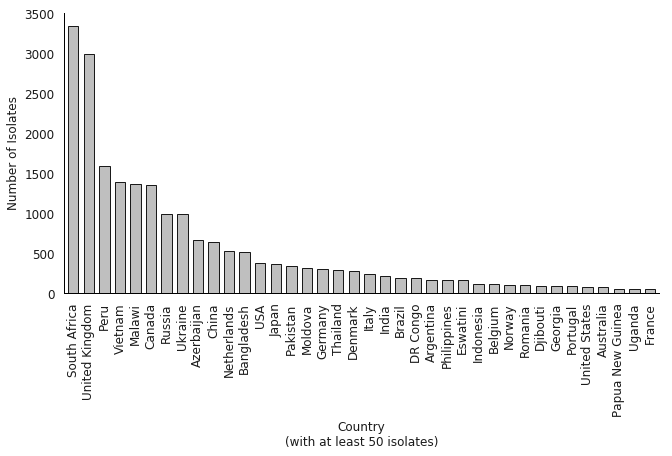

In [47]:
countries_with_many_isolates_series = num_isolates_per_country[num_isolates_per_country >= 50]

# data to plot
n_groups = np.shape(countries_with_many_isolates_series)[0]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.67
opacity = 1.0
edgecolor = 'k'
linewidth = 1.0

rects1 = plt.bar(index, countries_with_many_isolates_series, bar_width,
alpha=opacity,
color='0.75',
label='Countries with >= 50 samples',
linewidth = linewidth,
edgecolor = edgecolor)

plt.xlabel('Country\n(with at least 50 isolates)' , color = 'k' , fontsize = 12)
plt.ylabel('Number of Isolates', color = 'k' , fontsize = 12)
plt.xticks(index, countries_with_many_isolates_series.index, rotation = 90, fontsize = 11)
plt.xlim(min(index)-0.6, max(index)+0.6)
#plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(9.5, 6.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/figures/sample_breakdown_by_country.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [48]:
np.shape(countries_with_many_isolates_series)

(38,)

In [49]:
countries_with_many_isolates_series

South Africa        3340
United Kingdom      2987
Peru                1593
Vietnam             1391
Malawi              1362
Canada              1352
Russia               995
Ukraine              995
Azerbaijan           667
China                638
Netherlands          523
Bangladesh           518
USA                  376
Japan                369
Pakistan             346
Moldova              316
Germany              305
Thailand             288
Denmark              284
Italy                239
India                212
Brazil               190
DR Congo             189
Argentina            169
Philippines          166
Eswatini             160
Indonesia            122
Belgium              118
Norway               107
Romania               98
Djibouti              90
Georgia               86
Portugal              85
United States         77
Australia             75
Papua New Guinea      57
Uganda                54
France                51
dtype: int64

####################################################################################################################################################################################

# [5] Examine lineage distribution

####################################################################################################################################################################################

In [50]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group,country
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B,#
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B,#
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3,#
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B,#
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1,United Kingdom


In [51]:
num_isolates_per_global_lineage = pd.Series( Counter( isolate_annotation_DF.lineage_1 ) )

In [52]:
num_isolates_per_global_lineage

1     2815
2     8090
3     3398
4    16931
5       98
6       96
dtype: int64

#### Add counts for additional 12 *eis* C-14T mutants with AG MICs

In [53]:
isolate_annotation_DF_additional_isolates = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/eis_promoter_mutant_strains_from_Milan/Genotypes/Genotypes_Filtered/genotypes_isolate_annotation.pkl')

In [54]:
num_isolates_per_global_lineage['2']

8090

In [55]:
num_isolates_per_global_lineage['4']

16931

In [56]:
isolate_annotation_DF_additional_isolates

,lineage_call,isolate_ID
0,2.2.1.1.1,168-19
1,2.2.1.1.1.i3,622-19
2,4.2.1.2.1.1.i4.1,655-19
3,2.2.1.1.1.i3,IT1070
4,2.2.1.1.1,IT123
5,2.2.1.1.1,IT184
6,2.2.1.1.1.i3,IT233
7,4.2.1.1.1.1.1.1.i2,IT524
8,2.2.1.1.1.i3,IT634
9,2.2.1.1.1.i3,IT77


- IT123: 2
- IT184: 2
- IT952: 4
- IT524: 4
- 655-19: 4
- IT233: 2
- IT77: 2
- 622-19: 4
- IT1070: 2
- IT947: 2
- 168-19: 2
- IT634: 2

L2 + 8

L4 + 4

In [57]:
num_isolates_per_global_lineage['2'] = num_isolates_per_global_lineage['2'] + 8
num_isolates_per_global_lineage['4'] = num_isolates_per_global_lineage['4'] + 4

In [58]:
num_isolates_per_global_lineage['2']

8098

In [59]:
num_isolates_per_global_lineage['4']

16935

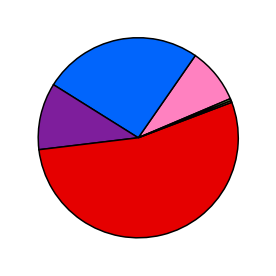

In [60]:
pie_slice_proportions = []
labels = []
colors = []

for lineage_call in num_isolates_per_global_lineage.index:
    
    proportion = float(num_isolates_per_global_lineage[lineage_call]) / float(num_isolates_per_global_lineage.sum())
    pie_slice_proportions.append(proportion)
    labels.append(lineage_call)
    
    if lineage_call[0] == '1':
        colors.append('xkcd:pink')
    if lineage_call[0] == '2':
        colors.append('xkcd:bright blue')
    if lineage_call[0] == '3':
        colors.append('xkcd:purple')
    if lineage_call[0] == '4':
        colors.append('xkcd:red')
    if lineage_call[0] == '5':
        colors.append('xkcd:light brown')
    if lineage_call[0] == '6':
        colors.append('xkcd:light green')
        
# Make square figures and axes
the_grid = GridSpec(1, 1)

fig, ax = plt.subplots()

wedges, texts = ax.pie(pie_slice_proportions, shadow=False , colors = colors , wedgeprops = {'linewidth': 12 } , labeldistance = 1.1 , startangle = 23)

fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.tight_layout()

for w in wedges:
    w.set_linewidth(1.5)
    w.set_edgecolor('black')
    
#for text in texts:
#    text.set_rotation(0)

file_name = '/n/data1/hms/dbmi/farhat/Roger/mmpR_BDQ_mutant_project/figures/Global_Lineage_Distribution_across_subjects.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
plt.show()

Make sure all **31,440** isolates are accounted for

In [61]:
float(num_isolates_per_global_lineage.sum())

31440.0